<a href="https://colab.research.google.com/github/IT17171366/Assignment-2--Deep-Dream/blob/main/Deep_Dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3595c338-f93c-cdab-b7a6-d7fb6733c2e4)


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import tensorflow as tf

In [ ]:
from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
from __future__ import print_function

In [ ]:
 

img_dir = '/content/images'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip
!wget --quiet -P /content/images/ https://sciencenode.org/img_2020/2020-06-29/golden-gate-bridge-san-francisco-2104742.jpg
!wget --quiet -P /content/images/ http://i.ebayimg.com/images/g/GjMAAOSwo4pYNNb1/s-l500.jpg
!wget --quiet -P /content/images/ https://www.arc2020.eu/wp-content/uploads/2019/07/smart-villages-pic.jpg

file_contents = open("/content/images/smart-villages-pic.jpg").read()  


model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

--2021-06-24 11:13:55--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.13.240, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  78.9MB/s    in 0.6s    

2021-06-24 11:13:56 (78.9 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 


W0624 11:13:59.921530 140495782168448 deprecation.py:323] From <ipython-input-5-6ff86801e9a2>:20: __init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


### Optional: Upload an image from your computer

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:

if type(uploaded) is not dict: uploaded = uploaded.files 
file_contents = uploaded[uploaded.keys()[0]]

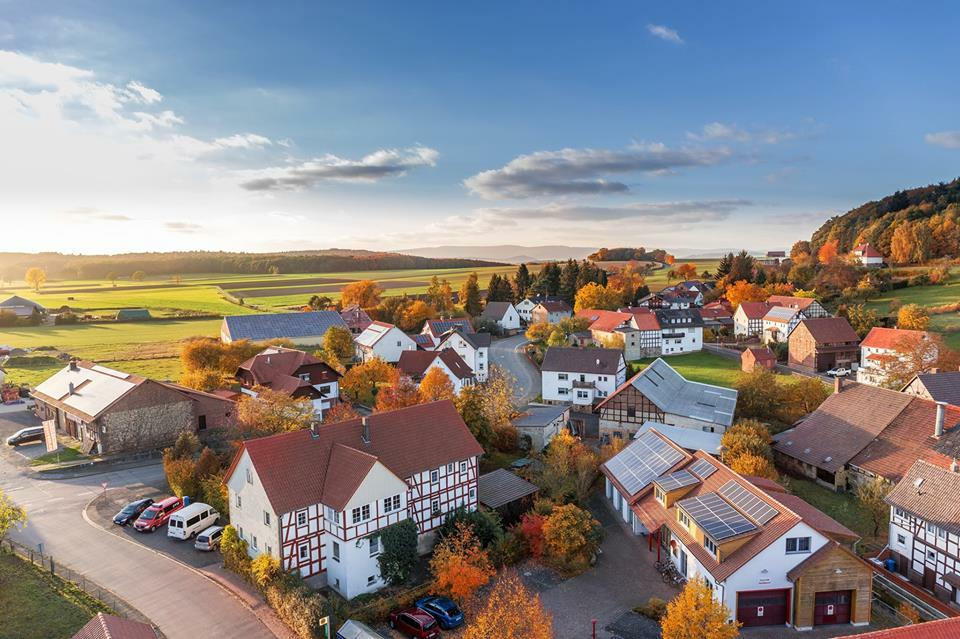

In [8]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
img0 = sess.run(tf.image.decode_image(file_contents))
showarray(img0)

In [9]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

for layer in layers:
  print('Layer:', layer)

Number of layers 59
Total number of feature channels: 7548
Layer: import/conv2d0_pre_relu/conv
Layer: import/conv2d1_pre_relu/conv
Layer: import/conv2d2_pre_relu/conv
Layer: import/mixed3a_1x1_pre_relu/conv
Layer: import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3a_3x3_pre_relu/conv
Layer: import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3a_5x5_pre_relu/conv
Layer: import/mixed3a_pool_reduce_pre_relu/conv
Layer: import/mixed3b_1x1_pre_relu/conv
Layer: import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3b_3x3_pre_relu/conv
Layer: import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3b_5x5_pre_relu/conv
Layer: import/mixed3b_pool_reduce_pre_relu/conv
Layer: import/mixed4a_1x1_pre_relu/conv
Layer: import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed4a_3x3_pre_relu/conv
Layer: import/mixed4a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed4a_5x5_pre_relu/conv
Layer: import/mixed4a_pool_reduce_pre_relu/conv
Layer: import/mixed4b_1

In [10]:
# These parameters let us control the strenth of the deepdream.
octave_n = 3
octave_scale = 1.4
iter_n = 50
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

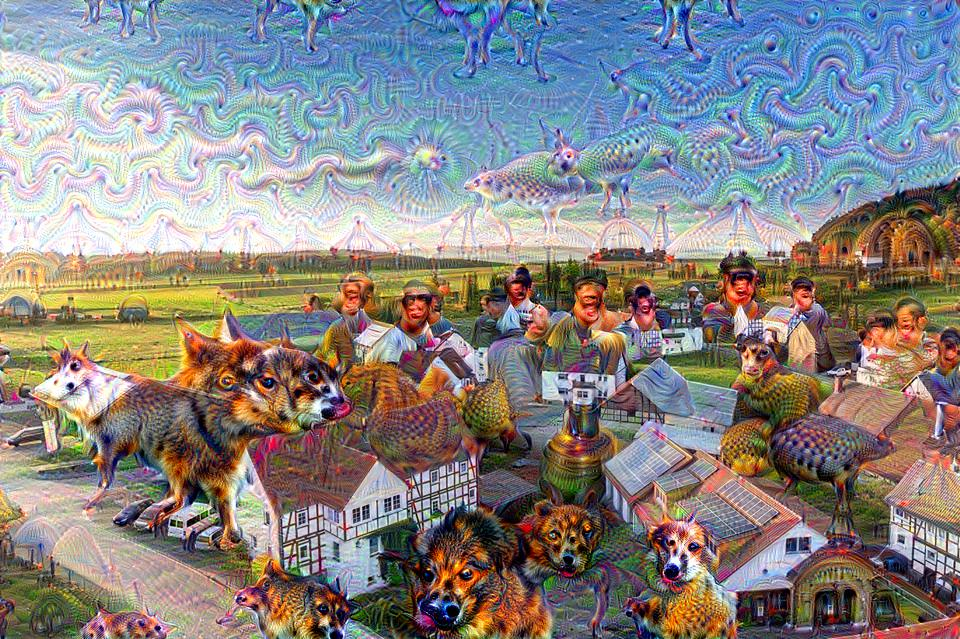

In [11]:
octave_n = 3 
octave_scale = 1.4
iter_n = 30 
strength = 200 
layer = "mixed4c"

final1 = render_deepdream(tf.square(T(layer)), img0)



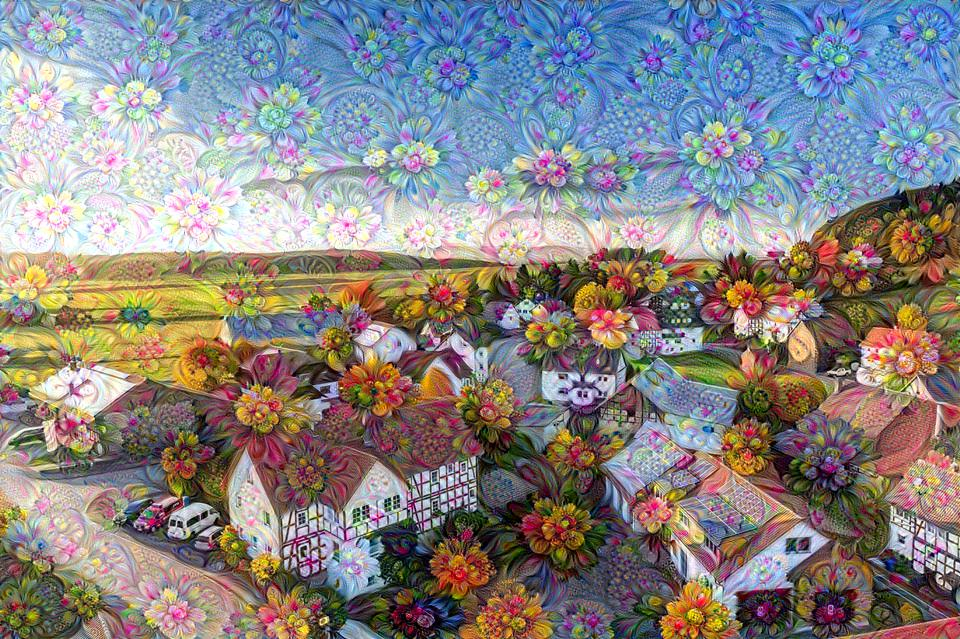

In [12]:
feature_channel = 139
layer = "mixed4d_3x3_bottleneck_pre_relu" 
if feature_channel >= T(layer).shape[3]:
  print("Feature channel exceeds size of layer ", layer, " feature space. ")
  print("Choose a smaller channel number.")
else:
  render_deepdream(T(layer)[:,:,:,feature_channel], img0)

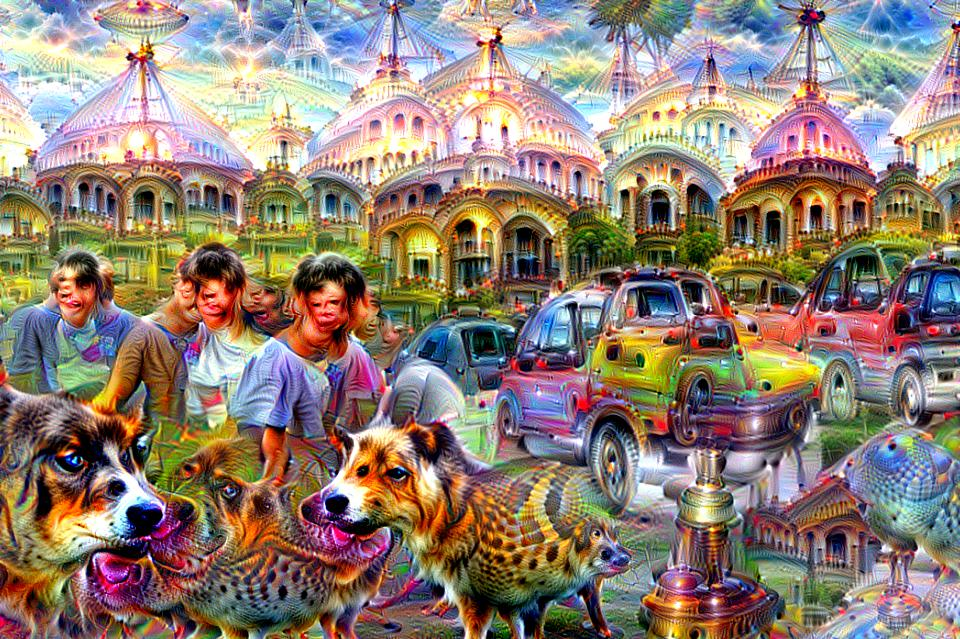

In [14]:
layer = "mixed4d_3x3_bottleneck_pre_relu" 
iter_n = 30 
strength = 150 
zooming_steps = 10 
zoom_factor = 1.1

frame = img0
img_y, img_x, _ = img0.shape
for i in range(zooming_steps):
  frame = render_deepdream(tf.square(T(layer)), frame, False)
  clear_output()
  showarray(frame)
  newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
  frame = resize(frame, newsize)
  frame = frame[(newsize[0]-img_y)//2:(newsize[0]-img_y)//2+img_y,
                (newsize[1]-img_x)//2:(newsize[1]-img_x)//2+img_x,:]
  

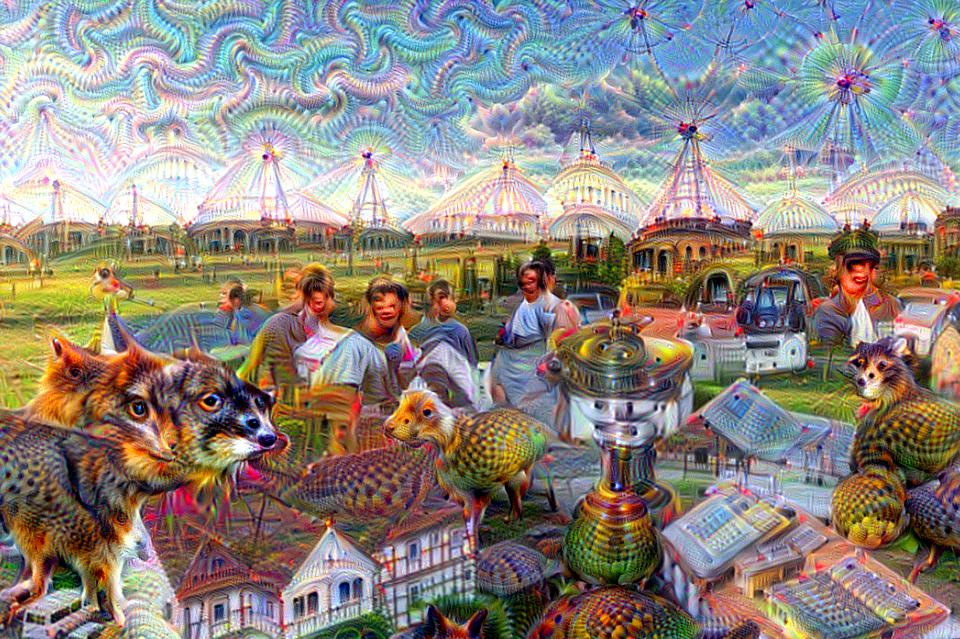

In [15]:
layer = "mixed4d_3x3_bottleneck_pre_relu" 
iter_n = 10 
strength = 200 
zooming_steps = 5 
zoom_factor = 1.1

frame = img0
img_y, img_x, _ = img0.shape
for i in range(zooming_steps):
  frame = render_deepdream(tf.square(T(layer)), frame, False)
  clear_output()
  showarray(frame)
  newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
  frame = resize(frame, newsize)
  frame = frame[(newsize[0]-img_y)//2:(newsize[0]-img_y)//2+img_y,
                (newsize[1]-img_x)//2:(newsize[1]-img_x)//2+img_x,:]
  

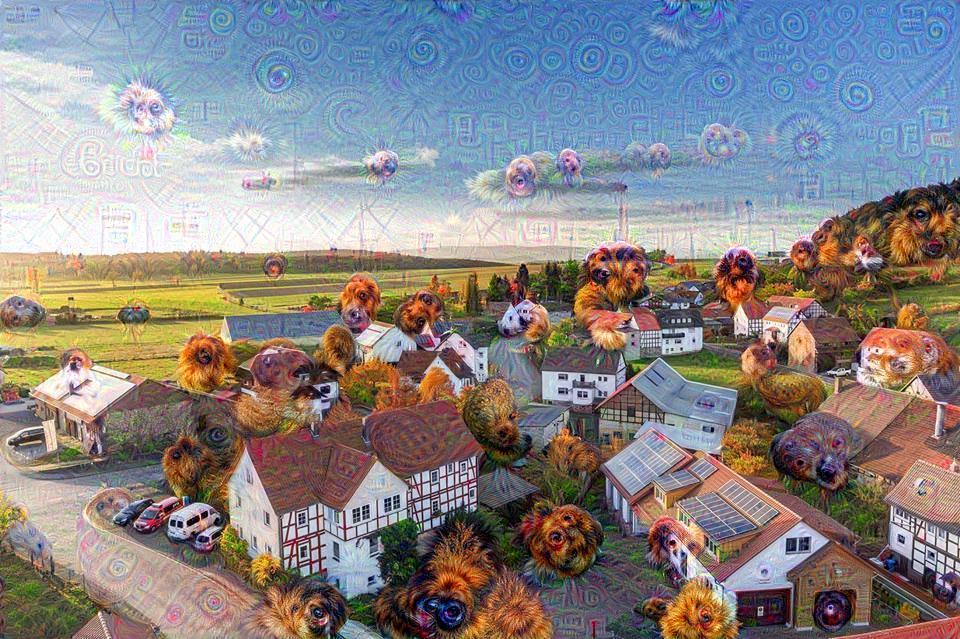

In [16]:
layer = "mixed4b_pool_reduce_pre_relu" #@param ["mixed3b", "mixed4a", "mixed4c", "mixed5a", "mixed4a_5x5_pre_relu", "mixed5b_1x1_pre_relu", "mixed5b_5x5_bottleneck_pre_relu", "mixed5b_pool_reduce_pre_relu", "conv2d0_pre_relu", "mixed3a_1x1_pre_relu", "mixed3b_3x3_bottleneck_pre_relu", "mixed4a_3x3_bottleneck_pre_relu", "mixed4a_1x1_pre_relu", "mixed4a_5x5_bottleneck_pre_relu", "mixed4b_pool_reduce_pre_relu", "mixed4d_3x3_bottleneck", "conv2d2_pre_relu", "mixed4a_pool_reduce_pre_relu", "head1_bottleneck_pre_relu", "head0_bottleneck_pre_relu", "mixed5b_pool_reduce_pre_relu"]
final = render_deepdream(tf.square(T(layer)), img0)

**Convert Your Deep Dream Image To Pencil Art**

In [17]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files

In [18]:
def read_file(filename):
  img = cv2.imread(filename)
  cv2_imshow(img)
  return img

**Upload  Your Deep Dream Image File**

Saving download.jpg to download.jpg


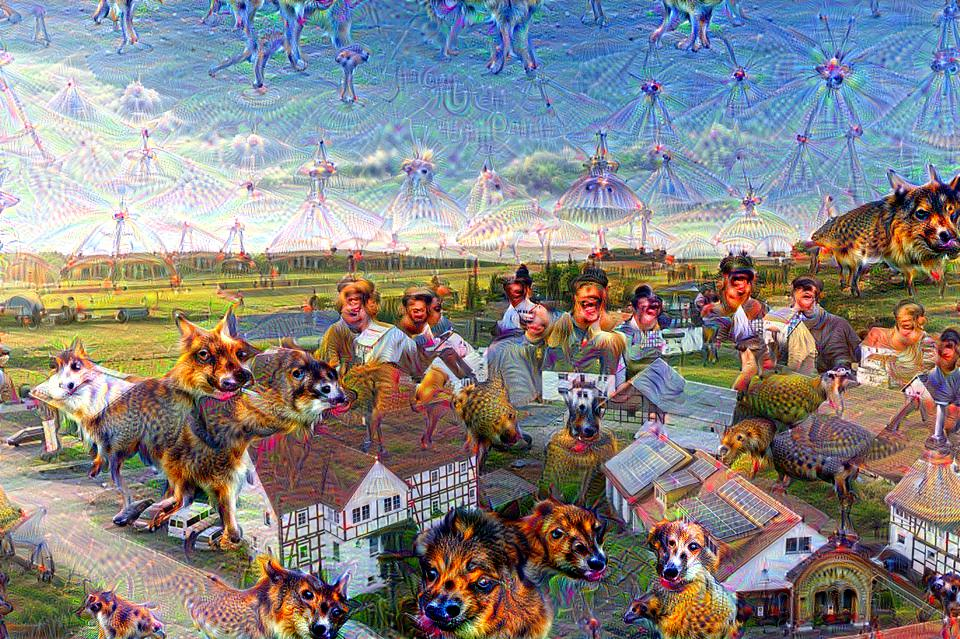

In [19]:
uploaded = files.upload()

filename = next(iter(uploaded))
img = read_file(filename)

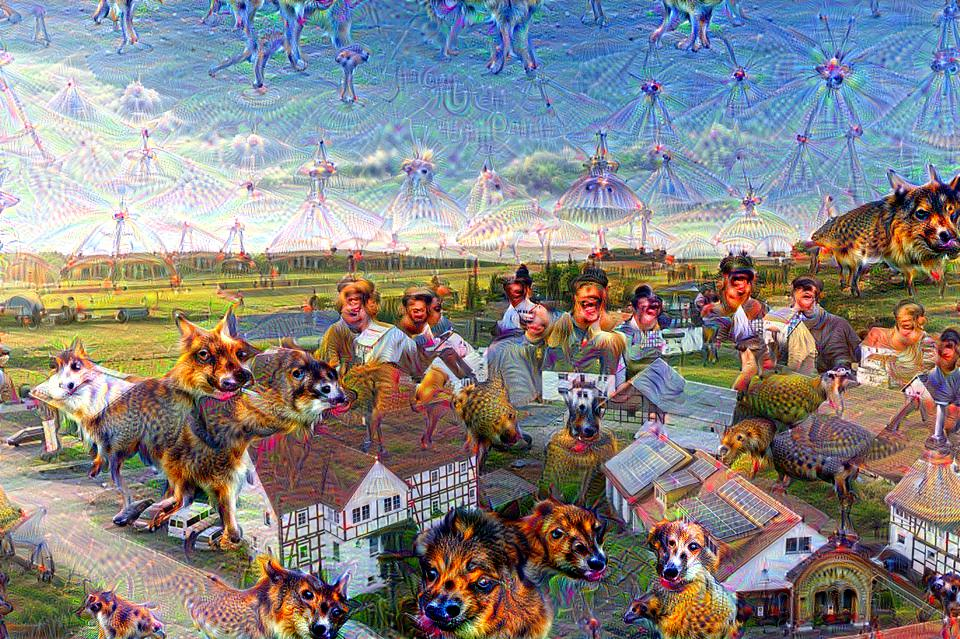

In [20]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2_imshow(img)

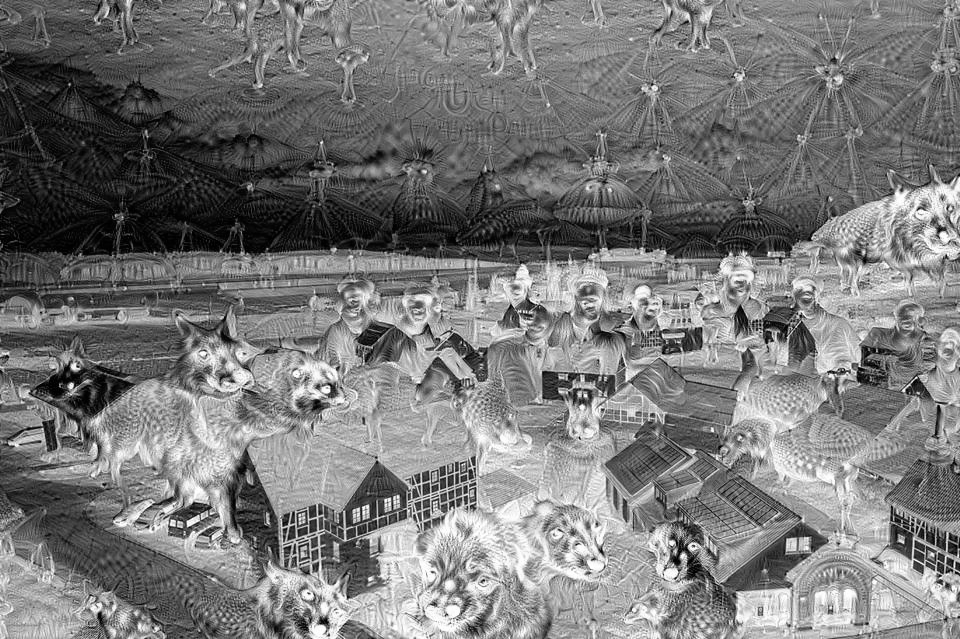

In [21]:
img_invert = cv2.bitwise_not(img_gray)

cv2_imshow(img_invert)

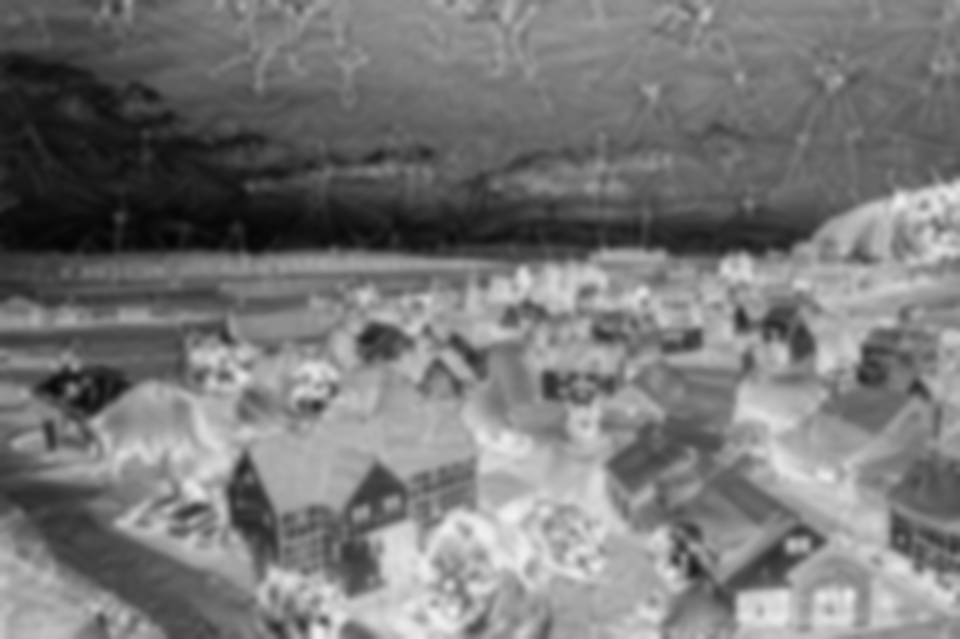

In [22]:
img_smoothing = cv2.GaussianBlur(img_invert, (21, 21),sigmaX=0, sigmaY=0)

cv2_imshow(img_smoothing)

In [23]:
def dodgeV2(x, y):

    return cv2.divide(x, 255 - y, scale=256)

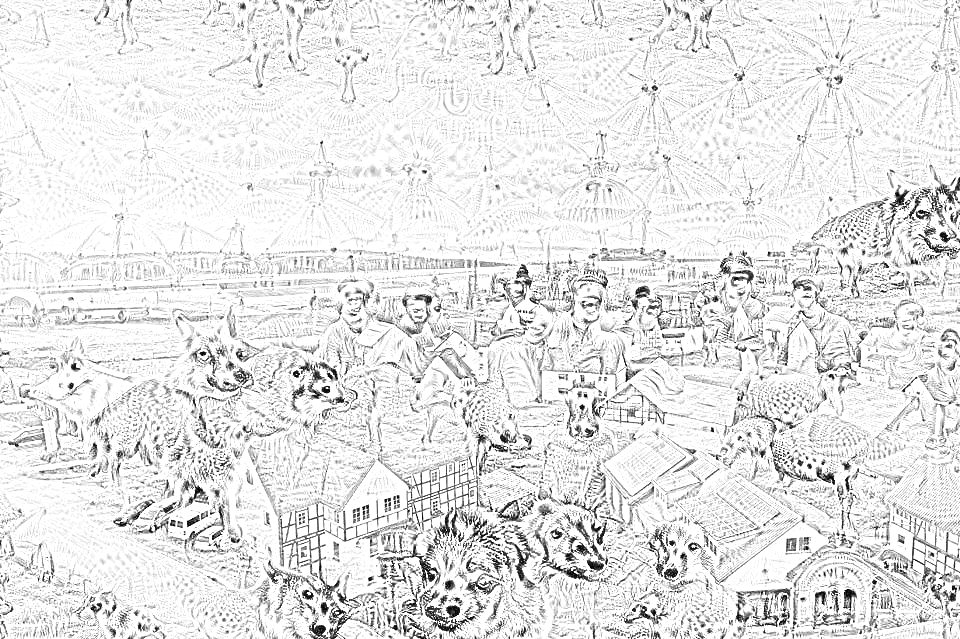

In [24]:
final_img = dodgeV2(img_gray, img_smoothing)

cv2_imshow(final_img)